# **Random Forest to predict Healthcare Costs**



Import and Load Libraries

In [ ]:
!pip install cudf-cu12 cuml-cu12 cupy-cuda12x

import numpy as np
import pandas as pd
import cupy as cp
import cudf

from cuml.ensemble import RandomForestRegressor as cuRFRegressor
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error as cu_mse
from cuml.metrics import r2_score as cu_r2

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Files

In [ ]:
# Define the correct folder path
base_path = "/content/drive/MyDrive/Capstone Project/Data/"

# Load feature datasets
X_train = pd.read_csv(base_path + "features_train.csv")
X_test = pd.read_csv(base_path + "features_test.csv")

# Load cost datasets (y values) and flatten them
y_train = pd.read_csv(base_path + "cost_train.csv").values.ravel()
y_test = pd.read_csv(base_path + "cost_test.csv").values.ravel()

# Verify dataset shape
print(f"Training Features: {X_train.shape}, Training Labels: {y_train.shape}")
print(f"Test Features: {X_test.shape}, Test Labels: {y_test.shape}")

Training Features: (1492974, 138), Training Labels: (1492974,)
Test Features: (639847, 138), Test Labels: (639847,)


Train Random Forest

In [ ]:
# Random Forest parameters (adjust these as needed)
param_values = {
    "n_estimators": 300,
    "max_depth": 20,
    "min_samples_split": 2,
    "max_features": "sqrt"
}

In [ ]:
# Convert full training data to GPU format
X_train_gpu = cudf.DataFrame.from_pandas(X_train).astype(np.float32)
y_train_gpu = cp.asarray(y_train).astype(np.float32)

# Convert test data as well
X_test_gpu = cudf.DataFrame.from_pandas(X_test).astype(np.float32)
y_test_gpu = cp.asarray(y_test).astype(np.float32)

In [ ]:
# Train model
cu_rf_regressor = cuRFRegressor(random_state=42, n_streams=1, **param_values)
cu_rf_regressor.fit(X_train_gpu, y_train_gpu)

RandomForestRegressor()

In [ ]:
# Make predictions
y_pred_gpu = cu_rf_regressor.predict(X_test_gpu)

In [ ]:
# Convert predictions back to CPU for evaluation
if isinstance(y_pred_gpu, cp.ndarray):
    y_pred = cp.asnumpy(y_pred_gpu)
else:
    y_pred = y_pred_gpu.to_numpy()

In [ ]:
# Calculate MSE, RMSE, and R_SQUARED
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = cu_r2(y_test, y_pred)

# Print results
print(f"XGBoost Model Performance:")
print(tabulate([
    ["MSE", f"{mse:.2f}"],
    ["RMSE", f"{rmse:.2f}"],
    ["R²", f"{r2:.4f}"]],
    headers=["Metric", "Value"],
    tablefmt="rounded_outline"))

XGBoost Model Performance:
╭──────────┬─────────╮
│ Metric   │   Value │
├──────────┼─────────┤
│ MSE      │    0.24 │
│ RMSE     │    0.49 │
│ R²       │    0.76 │
╰──────────┴─────────╯


Feature Selection

In [ ]:
# Get baseline score using GPU data
baseline_preds = cu_rf_regressor.predict(X_train_gpu)

In [ ]:
# Convert to CPU only for computing the metric
baseline_preds = cu_rf_regressor.predict(X_train_gpu)
if isinstance(baseline_preds, cp.ndarray):
    baseline_preds_np = cp.asnumpy(baseline_preds)
elif hasattr(baseline_preds, 'to_numpy'):
    baseline_preds_np = baseline_preds.to_numpy()
else:
    baseline_preds_np = baseline_preds

# Convert y to CPU for computing metrics
if isinstance(y_train_gpu, cp.ndarray):
    y_np = cp.asnumpy(y_train_gpu)
elif hasattr(y_train_gpu, 'to_numpy'):
    # Handle cuDF Series or DataFrame
    y_np = y_train_gpu.to_numpy()
else:
    # Fallback for other types
    y_np = y_train_gpu

In [ ]:
baseline_score = mean_squared_error(y_np, baseline_preds_np)
print(f"Baseline MSE: {baseline_score:.4f}")

Baseline MSE: 0.1570


In [ ]:
# Calculate importance for each feature
importances = []
feature_names = list(X_train.columns)  # Use CPU data just for column names
n_repeats = 2  # Number of times to permute each feature
batch_size = 1

In [ ]:
import gc

# Process one feature at a time
for feature_idx, col in enumerate(feature_names):
    print(f"Processing feature {feature_idx+1}/{len(feature_names)}: {col}")
    feature_importance = []

    for _ in range(n_repeats):
      # Create a shallow copy
      X_permuted_gpu = X_train_gpu.copy()

      # Extract column data and permute
      if hasattr(X_train_gpu[col], 'to_numpy'):
        feature_values = X_train_gpu[col].to_numpy()
        permuted_values = np.random.permutation(feature_values)
        X_permuted_gpu[col] = permuted_values
      elif isinstance(X_train_gpu[col], cp.ndarray):
        feature_values = cp.asnumpy(X_train_gpu[col])
        permuted_values = np.random.permutation(feature_values)
        X_permuted_gpu[col] = permuted_values
      else:
        # Handle other cases
        feature_values = X_train_gpu[col]
        permuted_values = np.random.permutation(feature_values)
        X_permuted_gpu[col] = permuted_values

      # Make prediction
      preds_gpu = cu_rf_regressor.predict(X_permuted_gpu)

      # Convert to numpy for scoring
      if isinstance(preds_gpu, cp.ndarray):
        preds_np = cp.asnumpy(preds_gpu)
      elif hasattr(preds_gpu, 'to_numpy'):
        preds_np = preds_gpu.to_numpy()
      else:
        preds_np = preds_gpu

      # Calculate importance
      permuted_score = mean_squared_error(y_np, preds_np)
      importance = permuted_score - baseline_score
      feature_importance.append(importance)

      # Clean up memory immediately
      del X_permuted_gpu
      del preds_gpu
      del preds_np

      # Force CUDA cleanup
      if hasattr(cp, 'get_default_memory_pool'):
        cp.get_default_memory_pool().free_all_blocks()
      elif hasattr(cp.cuda, 'Stream'):
        cp.cuda.Stream.null.synchronize()

    if feature_importance:
      # Only add if we have valid importance values
      mean_importance = np.mean(feature_importance)
      importances.append((col, mean_importance))
      print(f"  Importance: {mean_importance}")

    # Extra aggressive memory cleanup after each feature
    gc.collect()
    if hasattr(cp, 'get_default_memory_pool'):
        cp.get_default_memory_pool().free_all_blocks()

# Create final DataFrame
feature_importance_df = pd.DataFrame(importances, columns=['Feature', 'Importance'])

Processing feature 1/138: Age Group
  Importance: 2.7835369110107422e-05
Processing feature 2/138: Length of Stay
  Importance: 0.49411673843860626
Processing feature 3/138: Severity of Illness
  Importance: 0.03963182121515274
Processing feature 4/138: Risk of Mortality
  Importance: 0.0432128980755806
Processing feature 5/138: SVD_Component_1
  Importance: 0.01690022647380829
Processing feature 6/138: SVD_Component_2
  Importance: 0.020345740020275116
Processing feature 7/138: SVD_Component_3
  Importance: 0.031851984560489655
Processing feature 8/138: SVD_Component_4
  Importance: 0.0032273903489112854
Processing feature 9/138: SVD_Component_5
  Importance: 0.07965672016143799
Processing feature 10/138: SVD_Component_6
  Importance: 0.021465599536895752
Processing feature 11/138: SVD_Component_7
  Importance: 0.0030448883771896362
Processing feature 12/138: SVD_Component_8
  Importance: 0.0036405399441719055
Processing feature 13/138: SVD_Component_9
  Importance: 0.0030200183391571

In [ ]:
# Make sure importances are positive (if needed)
if feature_importance_df['Importance'].min() < 0:
    feature_importance_df['Importance'] = feature_importance_df['Importance'].abs()

In [ ]:
# Sort by importance (higher values = more important)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Check for and remove duplicate features
if feature_importance_df['Feature'].duplicated().any():
    feature_importance_df = feature_importance_df.drop_duplicates(subset=['Feature'])

In [ ]:
# Calculate the cumulative importance
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Normalized_Importance'] = feature_importance_df['Importance'] / total_importance
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Normalized_Importance'].cumsum()

In [ ]:
importance_thresholds = [0.95, 0.90, 0.85]
results = {}

# Evaluate models for different thresholds
for threshold in importance_thresholds:
    print(f"\nEvaluating threshold: {threshold}")

    # Select features based on cumulative importance threshold
    selected_features = feature_importance_df[feature_importance_df['Cumulative_Importance'] <= threshold]['Feature'].tolist()
    print(f"Selected {len(selected_features)} features ({len(selected_features)/len(feature_names):.1%} of original features)")

    # Free memory before creating feature subsets
    gc.collect()
    if hasattr(cp, 'get_default_memory_pool'):
        cp.get_default_memory_pool().free_all_blocks()

    # Create subsets with selected features
    X_train_selected = X_train_gpu[selected_features]
    X_test_selected = X_test_gpu[selected_features]

    # Train a new Random Forest model with the selected features
    rf_selected = cuRFRegressor(random_state=42, n_streams=1, **param_values)
    rf_selected.fit(X_train_selected, y_train_gpu)

    # Make predictions
    y_pred_gpu = rf_selected.predict(X_test_selected)

    # Convert to CPU for metric calculation
    if isinstance(y_pred_gpu, cp.ndarray):
        y_pred = cp.asnumpy(y_pred_gpu)
    elif hasattr(y_pred_gpu, 'to_numpy'):
        y_pred = y_pred_gpu.to_numpy()
    else:
        y_pred = y_pred_gpu

    # Convert test values to numpy
    if isinstance(y_test_gpu, cp.ndarray):
        y_test_np = cp.asnumpy(y_test_gpu)
    elif hasattr(y_test_gpu, 'to_numpy'):
        y_test_np = y_test_gpu.to_numpy()
    else:
        y_test_np = y_test_gpu

    # Calculate metrics
    mse_value = mean_squared_error(y_test_np, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = cu_r2(y_test_np, y_pred)

    # Store results
    results[threshold] = {
        'n_features': len(selected_features),
        'features': selected_features,
        'mse': mse_value,
        'rmse': rmse_value,
        'r2': r2_value,
        'model': rf_selected  # Store the model object
    }

    # Clean up after each threshold evaluation
    del X_train_selected
    del X_test_selected
    del rf_selected
    del y_pred_gpu
    gc.collect()
    if hasattr(cp, 'get_default_memory_pool'):
        cp.get_default_memory_pool().free_all_blocks()


Evaluating threshold: 0.95
Selected 108 features (78.3% of original features)

Evaluating threshold: 0.9
Selected 85 features (61.6% of original features)

Evaluating threshold: 0.85
Selected 66 features (47.8% of original features)


In [ ]:
# Print results
for threshold, metrics in results.items():
  print(tabulate([
      [f"Threshold: {threshold}"],
      [f"Number of Features: {metrics['n_features']}"],
      [f"MSE: {metrics['mse']:.2f}"],
      [f"RMSE: {metrics['rmse']:.2f}"],
      [f"R² Score: {metrics['r2']:.4f}"]],
      headers=["Metric", "Value"],
      tablefmt="rounded_outline"))

╭─────────────────────────╮
│ Metric                  │
├─────────────────────────┤
│ Threshold: 0.95         │
│ Number of Features: 108 │
│ MSE: 0.46               │
│ RMSE: 0.68              │
│ R² Score: 0.5432        │
╰─────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.9         │
│ Number of Features: 85 │
│ MSE: 0.46              │
│ RMSE: 0.68             │
│ R² Score: 0.5433       │
╰────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.85        │
│ Number of Features: 66 │
│ MSE: 0.46              │
│ RMSE: 0.68             │
│ R² Score: 0.5416       │
╰────────────────────────╯


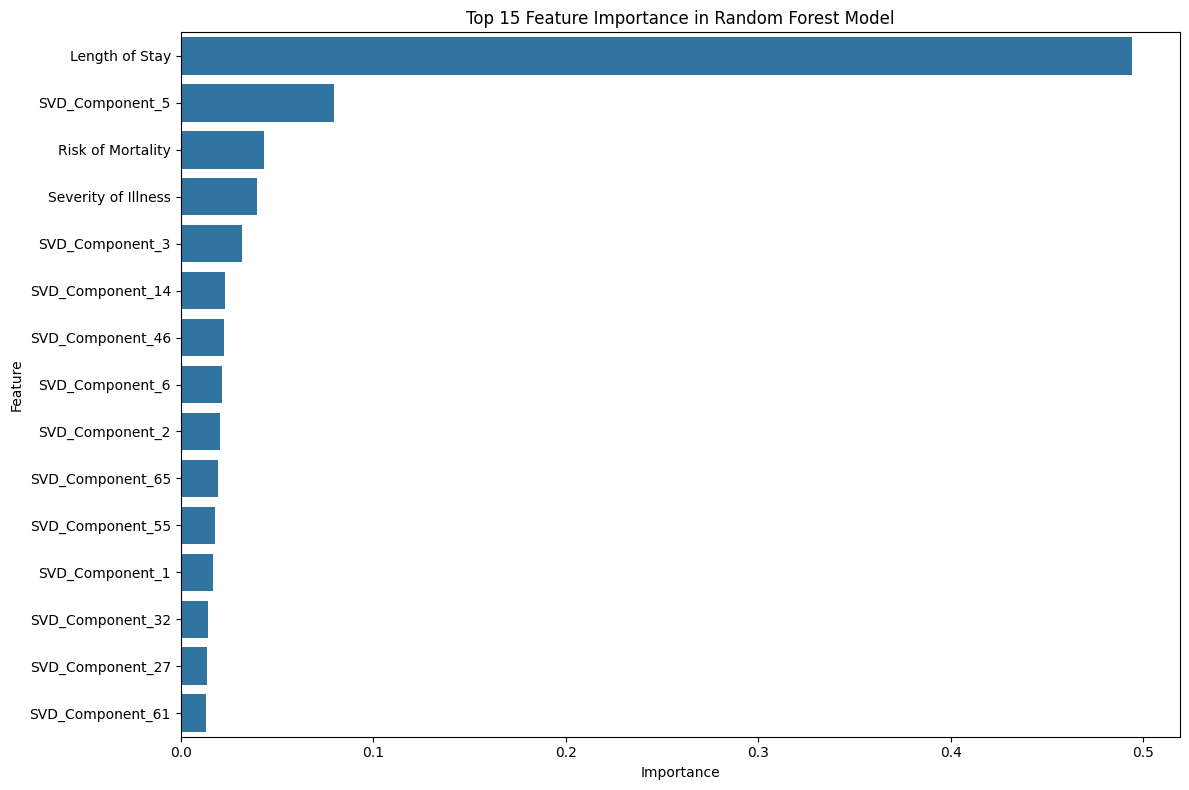

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Feature Importance in Random Forest Model')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

Save Model

In [ ]:
drive_path = "/content/drive/My Drive/Capstone Project/Code/Models/RandomForest/rf_model.joblib"
joblib.dump(cu_rf_regressor, drive_path)
print(f"Model saved to Google Drive: {drive_path}")

Model saved to Google Drive: /content/drive/My Drive/Capstone Project/Code/Models/RandomForest/rf_model.joblib
